In [5]:
import numpy as np
from importlib import reload
from scipy import signal

import plotting_tools as pt
import utils
utils = reload(utils)
pt = reload(pt)

import dill as pickle
import sys
import os
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../modules/')

import matplotlib.pyplot as plt
from matplotlib import rc
from palettable.cubehelix import red_16_r as ch2_16

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsfonts,amssymb,bm,mathrsfs}')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

import matplotlib.colors as mcolors
import matplotlib as mtl
cmap = mtl.colors.ListedColormap(ch2_16.mpl_colors)

In [17]:
i2 = (slice(2,-2),slice(2,-2))

def load(Nx,Ny,et,test):
    if test == 'mark':
        base_fn = 'output_mark_wave'
#     pydir = '../%s/' %base_fn
    pydir = '../%s/a0.5_dpl=2km/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et)
    tags = tc.get_tag_dict()
    
    return tc, tags

def get_ens(tc, times, sfx , diff, attribute, tag, SIDX, NIDX):
    idx = 0 if tag == 'ic' else -1
    times = [0] if tag == 'ic' else times
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=True,load_ic=True)[idx]

    label = sfx + '_' + attribute
    return label, ens.T[SIDX:NIDX,:]

def get_ens_all(tc, times, sfx , diff, attribute, tag, SIDX, NIDX):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=True,load_ic=True)
    ens = ens[:,:,SIDX:NIDX]
    return ens

def get_arr(typ, times, Nx, Ny, NIDX, tp='half', test='mark', et=8000.0):
    sfx1 = '%s' %typ

    tc, tags = load(Nx,Ny,et,test)
    if tp=='afs':
        tag = 'after_full_step'
    else:
        tag = tp

    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx1,format='dat')
    path_pickle = tc.get_path(fn_pickle)

#     print(path_pickle)
    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    mpv = pickle.load(file)
    dap = pickle.load(file)
    elem = pickle.load(file)
    file.close()
    
#     fi = open('test.json', 'w')
#     json_obj = jsonpickle.encode(ud)
#     json.dump(json_obj, fi)
#     json_obj = jsonpickle.encode(mpv)
#     json.dump(json_obj, fi)
#     json_obj = jsonpickle.encode(elem)
#     json.dump(json_obj, fi)
#     fi.close()

#     fi = open('test.json')
#     json_str = json.load(fi)
#     ud = jsonpickle.decode(json_str)
#     fi.close()

    S0 = (ud.stratification(elem.y)).reshape(-1,1)[2:-2,:][:NIDX]
    Y0 = mpv.HydroState.Y0[2:-2][:NIDX]
    
#     attributes = ['rhoX','rhou', 'rhov', 'rhoY', 'p2_nodes']
    attributes = ['rhov', 'rhoY', 'p2_nodes']
    _, rho = get_ens(tc, times, sfx1, diff, 'rho', tag, 0, NIDX)
    la = r''
    ret = []
    
    _, rhou = get_ens(tc, times, sfx1, diff, 'rhou', tag, 0, NIDX)
    u = rhou / rho
    u = u[i2]
#     ret.append([u, r' $u^\prime$'])
    ret.append([u, r' $\hat{u}$'])
    
    for attribute in attributes:
        _, aa = get_ens(tc, times, sfx1, diff, attribute, tag, 0, NIDX)
        if attribute == 'rhoY':
            la_curr = la + r' $\hat{\Theta}$'
        elif attribute == 'rhov':
            la_curr = la + r' $\hat{w}$'
        elif attribute == 'rhou':
            la_curr = la + r' $\hat{u}$'
        elif attribute == 'rhoX':
            la_curr = la + r' $\hat{\chi}$'
        else:
            la_curr = la + r' $\hat{\pi}$'
        
        if attribute == 'rhoY':
            aa = aa / rho
            aa -= S0
            aa = aa[i2]
        elif attribute == 'rhou':
            aa = aa / rho
            aa = aa[i2]
        elif attribute == 'rhov':
            aa = aa / rho
            aa = aa[i2]
        elif attribute == 'rhoX':
            aa = aa / rho
            aa = aa[i2]
        elif attribute == 'p2_nodes':
            aa = aa[i2]
            
        ret.append([aa,la_curr])
    
    return np.array(ret), (ud,mpv,elem), tc


def hatter(arrs, ud, mpv, elem, SIDX, NIDX):
    arrs_rhou, arrs_rhov, arrs_rhoY, arrs_pi, rhos = arrs
    
    rhobar = mpv.HydroState.rho0[2:-2][SIDX:NIDX]
    uhat = arrs_rhou / rhos * rhobar**0.5 * (ud.u_ref * np.sqrt(ud.rho_ref))
    vhat = arrs_rhov / rhos * rhobar**0.5 * (ud.u_ref * np.sqrt(ud.rho_ref))
    Nfq = ud.Nsq_ref**0.5
#     g = ud.gravity_strength[1] * ud.u_ref / ud.t_ref
    g = 9.81
    Ybar = mpv.HydroState.Y0[2:-2][SIDX:NIDX]
    S0 = (ud.stratification(elem.y)).reshape(1,1,-1)[:,:,2:-2][:,:,SIDX:NIDX]
    Yhat = g / Nfq * (rhobar**0.5 * np.sqrt(ud.rho_ref)) / Ybar * (arrs_rhoY / rhos - S0)
    p2c = np.array([signal.fftconvolve(mem,[[1,1],[1,1]], mode='valid')/4.0 for mem in arrs_pi])
    C = np.sqrt(1.4 * ud.u_ref**2/ud.Msq)
    p2hat = ud.cp_gas / C * (rhobar**0.5 * np.sqrt(ud.rho_ref)) * Ybar * p2c * ud.T_ref * ud.Msq
    
    return uhat, vhat, Yhat, p2hat

In [9]:
l_typ = 'WINDOW_STEP'
diff = False
attr_labels = pt.labels()

tp ='afs'
tag = 'after_full_step'
time_unit = 's'
N = 1

times0 = np.arange(31)

# Nxs = [151]
# Nys = [60]
Nxs = [301]
Nys = [120]
# Nxs = [601]
# Nys = [240]
# Nxs = [1201]
# Nys = [480]
Nts = [200,400,600,800,1000,1200,1400,1600]
# Nts = [600]
# Nts = [600]
# Nts = [1000,1200,1400,1600]
oms = ['', '_noom']

lu = np.arange(-0.004/2,0.004/2+0.0005,0.0005)
lv = np.arange(-0.0008/2,0.0008/2+0.0001,0.0001)
lrhoY = np.arange(-0.0006/2,0.0006/2+0.000075,0.000075)
# lrhoY = None
lp2n = np.arange(-0.001,0.00125,0.00025)

lu = [-0.1,-0.05,-0.025,-0.01,-0.005,-0.001,-0.0005,0.0,0.0005,0.001,0.005,0.01,0.025,0.05,0.1]
# lu = None
lv = np.linspace(-0.08,0.08,11)
lrhoY = np.linspace(-0.02,0.02,11)
lp2n = np.array([0.00025,0.0005,0.001,0.005,0.01,0.05,0.1])
lp2n = np.concatenate(((-1.0*lp2n)[::-1], [0], lp2n))

lu = [-0.06, -0.6, -6.0][::-1] + [0.0] + [0.06, 0.6, 6.0]
lv = [-0.04, -0.4, -4.0][::-1] + [0.0] + [0.04, 0.4, 4.0]
lrhoY = [-0.02, -0.2, -2.0][::-1] + [0.0] + [0.02, 0.2, 2.0]
lp2n = lu
lvls = [lu,lv,lrhoY,lp2n]

# ref: https://stackoverflow.com/questions/61897393/unevenly-irregularly-spaced-data-for-colorbar-with-evenly-spaced-colors
cmap_rb = plt.get_cmap('cubehelix')
lu_colors = cmap_rb(np.linspace(0, 1, len(lu) + 1))
lu_cm, lu_nm = mcolors.from_levels_and_colors(lu, lu_colors, extend='both')

lv_colors = cmap_rb(np.linspace(0, 1, len(lv) + 1))
lv_cm, lv_nm = mcolors.from_levels_and_colors(lv, lv_colors, extend='both')

lrhoY_colors = cmap_rb(np.linspace(0, 1, len(lrhoY) + 1))
lrhoY_cm, lrhoY_nm = mcolors.from_levels_and_colors(lrhoY, lrhoY_colors, extend='both')

lp2n_colors = cmap_rb(np.linspace(0, 1, len(lp2n) + 1))
lp2n_cm, lp2n_nm = mcolors.from_levels_and_colors(lp2n, lp2n_colors, extend='both')
cmaps = [[lu_cm,lu_nm],[lv_cm,lv_nm],[lrhoY_cm,lrhoY_nm],[lp2n_cm,lp2n_nm]]

for Nx, Ny in zip(Nxs,Nys):
#     print('NIDX = %i' %NIDX)
    
    for Nt in Nts:
        for om in oms:
            typ = 'bdl_run_S%i%s_a05' %(Nt,om)
            _,ics,tc = get_arr(typ,times0, Nx, Ny, Ny, tp=tp, et=720.0)
            
            ud, mpv, elem = ics[0], ics[1], ics[2]
            SIDX = np.abs(elem.y - 0.3).argmin()
            NIDX = int(SIDX+(Ny/4)+4)
#             print(elem.y[SIDX:NIDX])
#             print(elem.y[SIDX], elem.y[NIDX])
#             _ = get_ens_all(tc, times0, typ1, False, 'rho', tag, SIDX, NIDX)[:]

            t_axs = np.append(0,times0)
            phys_time = tc.t_arr

            if '_noom_' in typ:
                tcase = 'wo_omega'
                tstr = r'0.0'
                fld = 'noom'
            else:
                tcase = 'a05'
                tstr = '%.6f' %(ud.coriolis_strength[2] / ud.t_ref/ 2.0)
                fld = 'om'

            for idx,time in enumerate([times0[6]]):
#                 print(time)
                tp = 'ic' if time == 0 else 'afs'
#                 aa2,ics,_ = get_arr(typ1,[time], Nx, Ny, NIDX, tp=tp, et=720.0)
                tt = [time]
                rhos = get_ens_all(tc, tt, typ, False, 'rho', tag, SIDX, NIDX)[:]
                arrs_rhou = get_ens_all(tc, tt, typ, False, 'rhou', tag, SIDX, NIDX)[:]
                arrs_rhov = get_ens_all(tc, tt, typ, False, 'rhov', tag, SIDX, NIDX)[:]
                arrs_rhoY = get_ens_all(tc, tt, typ, False, 'rhoY', tag, SIDX, NIDX)[:]
                arrs_pi = get_ens_all(tc, tt, typ, False, 'p2_nodes', tag, SIDX, NIDX+1)[:]

                arrs = [arrs_rhou, arrs_rhov, arrs_rhoY, arrs_pi, rhos]
                arrs_hat = hatter(arrs, ud, mpv, elem, SIDX, NIDX)
                slc_idx = 0 if tt == 0 else -1
                arrs_hat = [arr[slc_idx,...].T for arr in arrs_hat]
                uhat, vhat, Yhat, p2hat = arrs_hat
#                 print(uhat.shape)

                ud, mpv = ics[0], ics[1]
                ct = 0.0 if time == 0 else time

                pl_lst = [[uhat, r"$\hat{u}$"],[vhat, r"$\hat{w}$"],[Yhat, r"$\hat{\theta}$"],[p2hat, r"$\hat{\pi}$"]]
                pl = pt.plotter(pl_lst,ncols=2,figsize=(30,16),sharey=False, fontsize=32)
                x_axs = np.array(np.linspace(ud.xmin,ud.xmax,7))
                y_axs = np.array(np.linspace(elem.y[SIDX],elem.y[NIDX-1],6))
#                 print(y_axs)

                x_axs = np.around(x_axs,2) * 10
                y_axs = np.around(y_axs,1)

                x_loc = np.linspace(0,(Nx-4)-1,7)
#                 y_loc = np.linspace(0,(Ny/4-1),6)
                
#                 print(elem.x)
                y_loc = np.linspace(3,NIDX-SIDX-1,5)
                y_axs = np.array([0.5,1.0,1.5,2.0,2.5]) * 10.0
#                 print(y_loc)

                x_label = r'$x$ [km]'
                y_label = r'$z$ [km]'

                pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)

                tu = ud.t_ref#/3600
#                 stitle = r'$\Omega_y = %s s^{-1}$, time-step = %i, time = %.2f %s' %(tstr, idx, phys_time[idx]*tu, time_unit)''
                print(tt, phys_time[tt[0]]*tu)
                stitle = r''
                _ = pl.plot(method='contour', lvls=lvls, cmaps=cmaps, suptitle=stitle, rect=[0, 0.03, 1, 0.95])

                fld_pth = './output_mark/%ix%i/S%i/%s' %(Nx,Ny,Nt,fld)
                if not os.path.exists(fld_pth):
                    os.makedirs(fld_pth)
                    
                pl.save_fig('%s/lamb_%s_%.3d' %(fld_pth, tcase,ct), format='.pdf')
#                 pl.save_fig('./output_mark/used/%sFinal' %fld)
#                 plt.show()
                plt.close()

/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[6] 1200.0
[6] 1200.0
[6] 2400.0
[6] 2400.0
[6] 3600.0
[6] 3600.0
[6] 4310.678899007294
[6] 4800.0
[6] 4857.199027974673
[6] 6000.0
[6] 5130.487335062033
[6] 7097.004383058157


KeyboardInterrupt: 

In [20]:
def get_norm(typ, times, Nx, Ny, NIDX):
    _,ics,tc = get_arr(typ,times, Nx, Ny, NIDX, tp=tp, et=720.0)
    ud, mpv, elem = ics
    tt = times
    
    didx = np.abs(elem.y - 0.3).argmin()
#     print(didx)
    SIDX = didx
    NIDX = int(SIDX+(Ny/4)+4)
    
    rhos = get_ens_all(tc, tt, typ, False, 'rho', tag, SIDX, NIDX)[:]
    arrs_rhou = get_ens_all(tc, tt, typ, False, 'rhou', tag, SIDX, NIDX)[:]
    arrs_rhov = get_ens_all(tc, tt, typ, False, 'rhov', tag, SIDX, NIDX)[:]
    arrs_rhoY = get_ens_all(tc, tt, typ, False, 'rhoY', tag, SIDX, NIDX)[:]
    arrs_pi = get_ens_all(tc, tt, typ, False, 'p2_nodes', tag, SIDX, NIDX+1)[:]
    
    ################################
    # w/ Dimensions
    ################################
    
    arrs = [arrs_rhou, arrs_rhov, arrs_rhoY, arrs_pi, rhos]
    uhat, vhat, Yhat, p2hat = hatter(arrs, ud, mpv, elem, SIDX, NIDX)
    
#     uhat = uhat / np.sqrt(1.4/ud.Msq)
#     vhat = vhat / np.sqrt(1.4/ud.Msq)

#     plt.figure(figsize=(8,6))
#     plt.imshow(uhat[2].T, origin='lower')
#     plt.axhline(didx)
#     plt.colorbar()
#     plt.grid()
#     plt.title("%i x %i" %(Nx,Ny))
#     plt.show()

#     plt.figure()
#     plt.plot(mpv.HydroState.Y0.reshape(-1))
#     plt.title("Y0: %i x %i" %(Nx,Ny))
#     plt.grid()
#     plt.show()
    
#     plt.figure()
#     plt.plot(ud.stratification(elem.y).reshape(-1))
#     plt.title("S0: %i x %i" %(Nx,Ny))
#     plt.grid()
#     plt.show()
    
    ################################
    # Dimensionless
    ################################
    
#     rhobar = mpv.HydroState.rho0[2:-2][:NIDX]
# #     rhobar = 1.0
#     uhat = arrs_rhou / rhos * rhobar**0.5
#     vhat = arrs_rhov / rhos * rhobar**0.5
#     Nfq = ud.Nsq_ref**0.5 * ud.t_ref
#     g = ud.gravity_strength[1]
#     Ybar = mpv.HydroState.Y0[2:-2][:NIDX]
#     Yhat = g / Nfq * (rhobar**0.5) / Ybar * (arrs_rhoY / rhos - Ybar)
#     p2c = np.array([signal.fftconvolve(mem,[[1,1],[1,1]], mode='valid')/4.0 for mem in arrs_pi])
#     gamma = 1.4
#     C = (np.sqrt(gamma/ud.Msq))
#     dcp = gamma * ud.Rg / (gamma-1.0)
#     p2hat = dcp / C * (rhobar**0.5) * Ybar * p2c

    ################################
    # Just the prognostic vars
    ################################
    
#     uhat = arrs_rhou / rhos * ud.u_ref
#     vhat = arrs_rhov / rhos * ud.u_ref
#     Ybar = mpv.HydroState.Y0[2:-2][:NIDX]
#     Yhat = (arrs_rhoY / rhos - Ybar) * ud.T_ref
#     p2c = np.array([signal.fftconvolve(mem,[[1,1],[1,1]], mode='valid')/4.0 for mem in arrs_pi])
#     p2hat = p2c

    t_axs = np.array(tc.t_arr)
    tt = t_axs * ud.t_ref

    res = []
    
    print(arrs_rhou.shape)
    for idx, arr in enumerate(arrs_rhou):
            
        u = uhat[idx]
        v = vhat[idx]
        Y = Yhat[idx]
        p = p2hat[idx]
        nnorm = np.array([u,v,Y,p])
#         nnorm = np.array([u])
#         nnorm = np.array([v])
#         nnorm = np.array([Y])
#         nnorm = np.array([p])
        if idx == 0:
            E0 = np.copy(la.norm(nnorm))
        res.append(la.norm(nnorm) / E0)
#         res.append(0.5*(u**2 + v**2 + Y**2 + p**2).sum())

    res = np.array(res)
    return res, ud, tt


def looper(Nxs,Nys,Nts,params,fs=(5,4),ftsz=10):
    pidx = 0
    nexps = []
    for Nx, Ny in zip(Nxs,Nys):
        for Nt in Nts:
            typ1 = 'bdl_run_S%i_a05' %Nt
            typ2 = 'bdl_run_S%i_noom_a05' %Nt
            NIDX = int((Ny/4)+4)
#             NIDX = Ny
#             print(NIDX, Nx,Ny,Nt, typ1, typ2)
            nts = 45 if (Nx == 151 and Ny == 60 and Nt == 1600) else 50
            times0 = np.arange(nts)

            res_om, ud_om, tt_om = get_norm(typ1, times0, Nx, Ny, NIDX)
            res_noom, ud_noom, tt_noom = get_norm(typ2, times0, Nx, Ny, NIDX)

            fig = plt.figure(figsize=(fs))
            fig.add_subplot(111)
            ax = plt.gca()

            tu_om = ud_om.t_ref
            tu_noom = ud_noom.t_ref
            
            if Nt < 600:
                me_om, me_noom = 2, 3
            else:
                me_om, me_noom = 1, 1
            ax.semilogy(tt_om, res_om, '-o', lw=2, markevery=me_om, label=r'$\Omega_y = %.3f \times 10^{-5}~$s$^{-1}$' %(ud_om.coriolis_strength[2] * 1e5 / tu_om / 2.0))
            ax.semilogy(tt_noom, res_noom, '--o', lw=2, markevery=me_noom, label=r'$\Omega_y = 0.0~$s$^{-1}$')
            
#             grads = res_om[1:] - res_om[:-1]
#             growth = (np.log(res_om[np.argmax(grads)+1]) - np.log(res_om[np.argmax(grads)])) / (tt_om[np.argmax(grads)+1] - tt_om[np.argmax(grads)])

#             fitted_exp = (np.log(growth) / np.log(10))
#             print(fitted_exp)

#             nexp, lls, ttshft_idx = params[pidx]
#             tts, tte = ttshft_idx
            tts, tte = params[pidx]
#             nexp = fitted_exp
#             nexp = -3.25
#             lls = 4
#             ttshft =tt_om[res_om.argmin()]
            res_rg = res_om[tts:tte+1]
            tt_rg = tt_om[tts:tte+1]
        
            grad, zb = np.polyfit(tt_rg, np.log(res_rg), 1)
#             ttshft = tt_om[tts]
#             print("argmin =", res_om.argmin())
#             lin_grad = np.log10((np.log(res_om[tte]) - np.log(res_om[tts])) / (tt_om[tte] - tt_om[tts]))
#             print("lin.grad =", lin_grad)
    #         params[pidx][0] = nexp
            ttfit = np.linspace(0,(tt_om[tte]-tt_om[tts]),5)
#             print(tt_om)
#             fitted = np.exp(10.0**(nexp)*ttfit)
            prep_grad = np.around(grad * 1e4,2)
            print("grid =", prep_grad)
            lgrad = np.log10(grad)
            print("lgrad =", lgrad)
            zbb = grad * tt_om[tts] + zb
            zbb = np.exp(zbb)
            fitted = zbb*np.exp(10.0**(lgrad)*ttfit)
#             ttf = tt_om #+ tt_om[np.argmax(grads)]
            ttf = ttfit
            ttf = ttf + tt_om[tts]

#             ax.semilogy(tt_om[tts:tte+1], res_om[tts:tte+1], 'C4', label="Help")
            ax.semilogy(ttf, fitted, 'k--', lw=2, label=r'$\mathscr{F}(t) = \mathscr{F}_0 \exp(%.2f \times 10^{-4}~t)$' %prep_grad)

            formatter = ticker.ScalarFormatter()
            formatter.set_scientific(True)
            formatter.set_powerlimits((-1,1))
            ax.yaxis.set_major_formatter(formatter)

            ymin, ymax = plt.gca().get_ylim()

#             ax.set_ylabel(r'$\Vert \psi \Vert^2$')
#             ax.set_ylabel(r'$\Vert \psi \Vert / \Vert \psi_0 \Vert$', fontsize=ftsz)
            ax.set_ylabel(r'$\log_{10}$[rel. norm]', fontsize=ftsz)
#             ax.set_ylabel(r'$\Vert \psi \Vert$')
            t_units = 's'
            ax.set_xlabel("time $t$ [%s]" %t_units, fontsize=ftsz)
#             ax.set_title("(%i x %i) at S%i" %(Nx,Ny,Nt), fontsize=ftsz)
#             ax.grid()
            ax.legend(fontsize=int(ftsz-1))
            ax.set_xlim([0.0,tt_om.max()])
#             ax.set_ylim([0.0,10.0])
            xtl = ax.get_xticks()
            ytl = ax.get_yticks()
            ax.set_xticklabels(xtl, fontsize=ftsz)
            ax.set_yticklabels(ytl, fontsize=ftsz)
            fld_pth = './output_mark/%ix%i/S%i' %(Nx,Ny,Nt)
            if not os.path.exists(fld_pth):
                os.makedirs(fld_pth)
            plt.tight_layout()
#             plt.savefig('./output_mark/%ix%i/S%i/plot.pdf' %(Nx,Ny,Nt))
#             plt.savefig('./output_mark/used/plot.pdf')
            plt.show()

            pidx += 1
            
            nexps.append(lgrad)
    return nexps

/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(51, 601, 64)
(51, 601, 64)
grid = 11.08
lgrad = -2.955322120900675


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:191: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:192: UserWarning: FixedFormatter should only be used together with FixedLocator


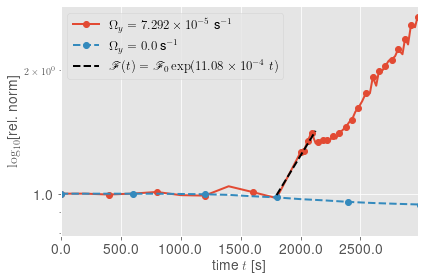

[-2.955322120900675]


In [23]:
from matplotlib.ticker import (FixedLocator)
from matplotlib import ticker
import matplotlib
# matplotlib.rcParams.update({'font.size': 6})
plt.style.use('ggplot')

from numpy import linalg as la
import csv

l_typ = 'WINDOW_STEP'
diff = False

attr_labels = pt.labels()

Nxs = [151,301,601,1201]
Nys = [60,120,240,480]
# Nxs = [120,120]
# Nys = [120,240]
# Nxs = [151]
# Nys = [60]
# Nxs = [301]
# Nys = [120]
Nxs = [601]
Nys = [240]
# Nxs = [1201]
# Nys = [480]
# Nxs = [151, 301, 601, 1201]
# Nys = [60, 120, 240, 480]
# Nts = [200,400,600,800,1000,1200,1400,1600]
# Nts = [600]
# Nts = [200,400,600,800,1000]
# Nts = [400,600,800]
Nts = [200]
# Nts = [1200,1400,1600]

N = 1
et = 720.0
nts = 50

tp = 'afs'
attribute = 'rhou'
tag = 'after_full_step'

params = [
# 151x60
#         [34,36],
#         [14,16],
#         [8,11],
#         [4,8],
#         [4,7],
#         [4,5],
#         [4,5],
#         [4,5],
# 301x120
#         [15,34],
#         [6,9],
#         [3,5],
#         [3,4],
#         [3,4],
#         [3,4],
#         [3,4],
#         [2,4],
# 601x240
        [9,17],
        [3,5],
        [2,4],
        [2,3],
        [2,3],
        [2,3],
        [2,3],
        [2,3],
# 1201x480
#         [5,7],
#         [2,4],
#         [2,3],
#         [2,3],
#         [2,3],
#         [2,3],
#         [2,3],
#         [2,3],
         ]

# params = [(3,5)]

nexps = looper(Nxs,Nys,Nts,params,fs=(6,4),ftsz=14)
print(nexps)

output = False
if output:
    labels = []
    for Nx, Ny in zip(Nxs,Nys):
        for Nt in Nts:
            labels.append('%ix%i_S%i' %(Nx,Ny,Nt))
            
    f = open('params', 'a')
    writer = csv.writer(f)
    for ridx, row in enumerate(params):
        row.insert(0, labels[ridx])
        writer.writerow(row)
    f.close()


In [6]:
10**-3.14213442132599

0.0007208843190276228

In [84]:
# attempt 1
r1 = [-3.3545037866287317, -3.5051170803764435, -3.1802749647708555, -3.3986602924543226, -3.2629578528527854, -3.2931658926711966, -3.1353412993522536, -2.6107068470558543]
r2 = [-2.8287131051603667, -2.9761550045321545, -3.11959440875742, -3.0036249480970993, -3.018972113412658, -2.7676738289779026, -2.580580881663709, -3.1100636864362623]
r3 = [-2.9687280946868713, -2.943902221976006, -2.948517222690123, -3.419397211814551, -3.3877486472601634, -3.3982503502133508, -3.3982503502133508, -3.3982503502133508]
r4 = [-2.479972663620796, -2.784557899772692, -3.2756712388429587, -3.2756712388429587, -3.2756712388429587, -3.2756712388429587, -3.2756712388429587, -3.2756712388429587]

# fixed theta comp
r1 = [-3.268587369000301, -3.4825619191349686, -3.172512645518122, -3.3063692522837176, -3.199578503470238, -3.2158594027628475, -3.0687822587794673, -2.582052680613442]
r2 = [-2.805956457552443, -2.953639888637499, -3.14213442132599, -3.0557811331761258, -2.9696309329103157, -2.736561534884991, -2.5532790319588234, -3.044171754407027]
r3 = [-2.955322120900699, -2.9072880778451227, -2.926853860634512, -3.356723401291692, -3.3339811171041185, -3.3444880803125994, -3.3444880803125994, -3.3444880803125994]
r4 = [-2.4758224600266634, -2.7766153466764787, -3.2608002179719966, -3.2608002179719966, -3.2608002179719966, -3.2608002179719966, -3.2608002179719966, -3.2608002179719966]

RR = np.array([r1,r2,r3,r4])
data = np.copy(10**RR) * 10**4
data = np.around(data,2)

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        skips = ((2,6),(2,7),(3,3),(3,4),(3,5),(3,6),(3,7))
        for (i,j) in skips:
            data[i,j] = np.nan

from mpl_toolkits.axes_grid1 import make_axes_locatable

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="8%", pad=0.05)
    cax1 = cax.twinx()
    cax.yaxis.set_ticks_position('right')
#     cbar = ax.figure.colorbar(im, ax=cax, **cbar_kw)
    cbar = plt.colorbar(im, cax=cax, **cbar_kw)
#     cbar.ax.set_xlabel(cbarlabel)
#     cbar.ax.xaxis.set_label_coords(100,100)
    cbar.ax.set_ylabel(cbarlabel, rotation=0)
    cbar.ax.yaxis.set_label_coords(0.9,1.075)
    cax1.grid(False, which="major")
    for j, lab in enumerate(['',r'$-50\%$',r'$-25\%$',r'$\pm10\%$',r'$+25\%$',r'$+50\%$','']):
        cax1.text(.5, (j+0.5) / 7.0, lab, ha='center', va='center', rotation=-0)
    cax1.set_yticks([])

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-0, ha="center",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.set_xlabel("Temporal step size~[s]")
    ax.xaxis.set_label_position('top')
    ax.set_ylabel("Spatial resolution\n[number of grid points]")
    ax.grid(which="minor", color="w", linestyle='-', linewidth=4)
    ax.grid(False, which="major")
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
#     if threshold is not None:
#         threshold = im.norm(threshold)
#     else:
#         threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mtl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
#             kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
    
            skips = ((2,6),(2,7),(3,3),(3,4),(3,5),(3,6),(3,7))
            if (i,j) in skips:
                text = im.axes.text(j, i, "", **kw)
                texts.append('')
            else:
                if threshold is not None:
                    kw.update(color=textcolors[int(data[i, j] < threshold[0] or data[i, j] > threshold[1])])
                    
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
                texts.append(text)
    return texts


[[ 5.39  3.29  6.72  4.94  6.32  6.08  8.54 26.18]
 [15.63 11.13  7.21  8.79 10.72 18.34 27.97  9.03]
 [11.08 12.38 11.83  4.4   4.63  4.52   nan   nan]
 [33.43 16.73  5.49   nan   nan   nan   nan   nan]]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


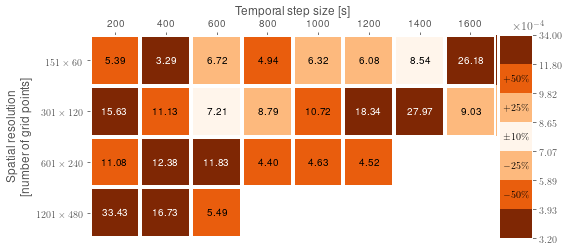

In [116]:
vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
              "potato", "wheat", "barley"]
farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])

resos = [r'$151 \times 60$',r'$301 \times 120$',r'$601 \times 240$',r'$1201 \times 480$']
treses = [r'200',r'400',r'600',r'800',r'1000',r'1200',r'1400',r'1600']

from matplotlib import colors
# divnorm=colors.TwoSlopeNorm(vmin=-3.6, vcenter=-3.1, vmax=-2.4)
# norm = matplotlib.colors.BoundaryNorm([-3.6,-3.406, -3.230, -3.150, -3.063, -3.008, -2.929, -2.4], 7)
divnorm=colors.TwoSlopeNorm(vmin=-3.6, vcenter=7.85, vmax=34)
norm = matplotlib.colors.BoundaryNorm([3.20,3.93, 5.89, 7.07, 8.65, 9.82, 11.8, 34.0], 7)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top = cm.get_cmap('Oranges_r', 4)
middle = cm.get_cmap('Oranges_r', 1)
bottom = cm.get_cmap('Oranges', 4)

newcolors = np.vstack((top(np.linspace(0, 1, 4)[:-1]),
                       middle(np.linspace(0, 1, 1)),
                       bottom(np.linspace(0, 1, 4)[1:])
                      ))
newcmp = ListedColormap(newcolors, name='OrangeDivergence')

print(data)

plt.figure(figsize=(8,8))
# plt.figure()
ax = plt.gca()
# im, cbar = heatmap(data, resos, treses, ax=ax, cmap="PRGn", cbarlabel="")
# texts = annotate_heatmap(im, valfmt="{x:.1f} t")
cmap = plt.get_cmap("PRGn", 7)
cmap = newcmp
cmap.set_bad(color='white', alpha = 1.)
im, cbar = heatmap(data, resos, treses, ax=ax, cmap=cmap, cbarlabel=r"$\times 10^{-4}$", norm=norm)
texts = annotate_heatmap(im, valfmt="{x:.2f}", threshold=[3.93,11.80])
plt.tight_layout()
plt.savefig("./output_mark/used/heatMap.pdf")
plt.show()


In [77]:
xp = -3.104615552507752

print(10**xp)

a = 0.5*10**xp
b = 1.5*10**xp
print(a,b)

a = 0.75*10**xp
b = 1.25*10**xp
print(a,b)

a = 0.90*10**xp
b = 1.10*10**xp
print(a,b)

0.0007859310510589729
0.00039296552552948647 0.0011788965765884593
0.0005894482882942296 0.0009824138138237162
0.0007073379459530757 0.0008645241561648703


In [32]:
xp = -3.104615552507752

print(10**xp)
a = 0.5*10**xp
b = 1.5*10**xp
print(a,b)

a = np.log10(0.75*10**xp)
b = np.log10(1.25*10**xp)
print(a,b)

a = 0.90*10**xp
b = 1.10*10**xp
print(a,b)

0.0007859310510589729
0.00039296552552948647 0.0011788965765884593
-3.229554289116052 -3.0077055394996957
0.0007073379459530757 0.0008645241561648703
